# Proposal Abstract
According to the World Health Organization, stroke is the second leading cause of death globally. Thus, our group thinks that predicting the probability of getting a stroke in advance and interfering in time is crucial. In this project, we will train models with the dataset Stroke Prediction Dataset (https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) using logistic regression, LDA, KNN and other possible models to predict whether a patient would get stroke.

We would like to build a classifier that can predict the onset of stroke with high accuracy (hopefully near 90%). The takeaway of our project is that we hope the features which constitute our most accurate classifier can serve as precautionary factors in preventing stroke with some grain of truth.

After thorough consideration and discussion among project partners, we believe it is better to use supervised learning methods since our data has clear labels (get stroke/ does not get stroke). In addition, as the prediction of our prediction is categorical, consisting of exactly two categories, we recognize that building a classifier via logistic regression should be the most appropriate approach in addressing the dataset and our project's interest.

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import itertools
from statsmodels.formula.api import logit
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Brief Data Visualization and Simple Exploratory Analysis
We would like to first double-check that our dataset doesn't violate any basic assumptions about logistic regression, such as multi-colinearity, extreme outliers, homoscedasticity, etc..

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.set_index('id', inplace = True)

data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


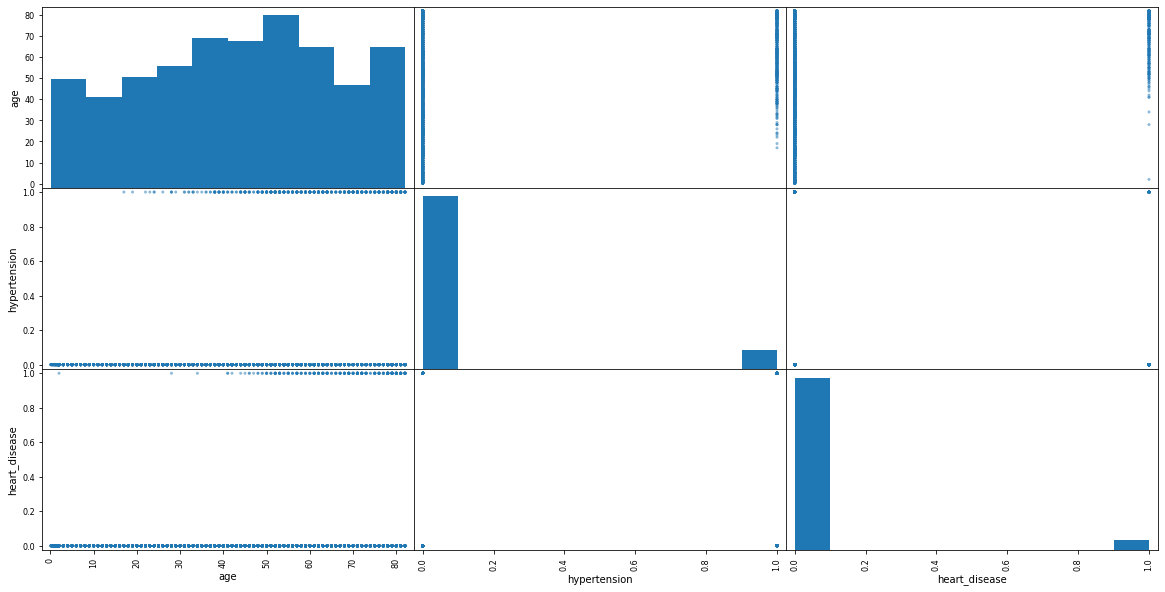

In [3]:
overview_1 = pd.plotting.scatter_matrix(data.iloc[:, :6], figsize = (20, 10))

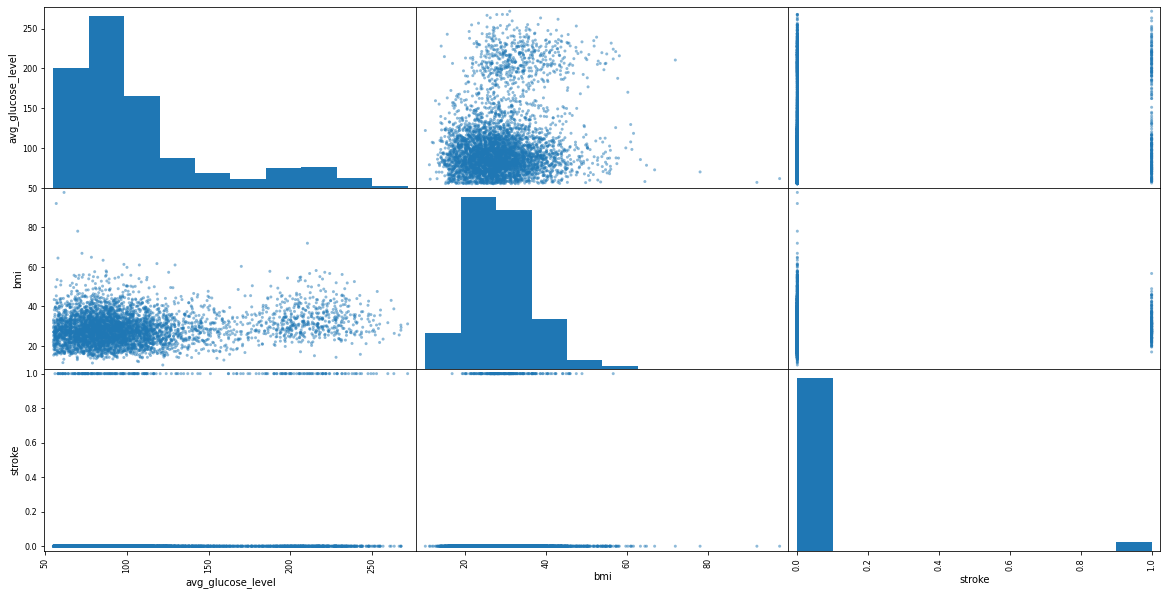

In [4]:
overview_2 = pd.plotting.scatter_matrix(data.iloc[:, 6:], figsize = (20, 10))

In [5]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

So far what we've noticed are:

1. There are 5 predictor variables that are stored as strings, which would require us to convert them first to dummy variables.
2. There are 201 missing observations from the "bmi" column. We would have to either remove these observations and somehow compensate for the missing values before proceeding to building our model. In addition, as it is noted on Kaggle, where our dataset is published from, the "unknown" entries in "smoking status" also means that the information was unavailable, i.e. NaN, from the patient. We then need to account for this, too.
3. Our scatter matrix shows that our dataset does not violate the assumptions to performing logistic regression.

In [6]:
data.dropna(inplace = True) # Drop the N/A values from bmi.
data = data[data['smoking_status'] != 'Unknown'] # Drop the Unknown values from smoking status.
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
68398,Male,82.0,1,0,Yes,Self-employed,Rural,71.97,28.3,never smoked,0
45010,Female,57.0,0,0,Yes,Private,Rural,77.93,21.7,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0


# Encoding Categorical Predictor Variables into Dummy Variables    

In [7]:
print(data['gender'].unique(), 
      data['ever_married'].unique(),
      data['work_type'].unique(),
      data['Residence_type'].unique(),
      data['smoking_status'].unique()
     )

['Male' 'Female' 'Other'] ['Yes' 'No'] ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked'] ['Urban' 'Rural'] ['formerly smoked' 'never smoked' 'smokes']


We have five categorical variables. 

Two of which, `ever_married` and `Residence type`, are binary and we will encode them conventionally using 0's and 1's.

Of all the other non-binary categorical variables, we will have to create k - 1 dummy variables to represent them numerically, where k is each of their numbers of different levels.

In [8]:
# This section of code is borrowed from:
# https://medium.com/@urvashilluniya/convert-multiple-categorical-columns-into-numeric-columns-in-single-line-of-code-577bab825635
df = pd.get_dummies(data, columns = ['gender',
                                               'ever_married',
                                               'work_type',
                                               'Residence_type',
                                               'smoking_status'
                                              ], 
                              drop_first = True
                             )
# 修改列名
df["work_type_Self_employed"] = df["work_type_Self-employed"]
df.drop("work_type_Self-employed", axis = 1, inplace = True)
df.drop("gender_Other", axis = 1, inplace = True)
df["smoking_status_never_smoked"] = df["smoking_status_never smoked"]
df.drop("smoking_status_never smoked", axis = 1, inplace = True)
df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_children,Residence_type_Urban,smoking_status_smokes,work_type_Self_employed,smoking_status_never_smoked
id,,,,,,,,,,,,,,,
9046,67.0,0,1,228.69,36.6,1,1,1,0,1,0,1,0,0,0
31112,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,0,1
60182,49.0,0,0,171.23,34.4,1,0,1,0,1,0,1,1,0,0
1665,79.0,1,0,174.12,24.0,1,0,1,0,0,0,0,0,1,1
56669,81.0,0,0,186.21,29.0,1,1,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68398,82.0,1,0,71.97,28.3,0,1,1,0,0,0,0,0,1,1
45010,57.0,0,0,77.93,21.7,0,0,1,0,1,0,0,0,0,1
44873,81.0,0,0,125.20,40.0,0,0,1,0,0,0,1,0,1,1


In [42]:
columns = list(df.columns.values)
columns = np.delete(columns, 5)
X = df[columns]
y = df["stroke"]
print(f"Original: {Counter(y)}")
over = RandomOverSampler(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
X_over, y_over = over.fit_resample(X, y)
print(f"Oversampled: {Counter(y_over)}")
# now to comine under sampling 
X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)
print(f"Combined Random Sampling: {Counter(y_combined_sampling)}")
print(columns)
X_combined_sampling["stroke"] = y_combined_sampling
df = X_combined_sampling
df

Original: Counter({0: 3246, 1: 180})
Oversampled: Counter({0: 3246, 1: 1298})
Combined Random Sampling: Counter({0: 2163, 1: 1298})
['age' 'hypertension' 'heart_disease' 'avg_glucose_level' 'bmi'
 'gender_Male' 'ever_married_Yes' 'work_type_Never_worked'
 'work_type_Private' 'work_type_children' 'Residence_type_Urban'
 'smoking_status_smokes' 'work_type_Self_employed'
 'smoking_status_never_smoked']


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_children,Residence_type_Urban,smoking_status_smokes,work_type_Self_employed,smoking_status_never_smoked,stroke
0,55.0,0,0,89.43,26.1,0,1,0,0,0,1,0,0,0,0
1,53.0,1,0,216.88,31.4,0,1,0,1,0,0,1,0,0,0
2,71.0,1,0,186.95,33.3,1,1,0,1,0,0,0,0,1,0
3,28.0,0,1,111.27,19.1,0,1,0,1,0,0,1,0,0,0
4,55.0,0,0,62.56,28.6,1,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3456,56.0,1,0,249.31,35.8,1,1,0,1,0,0,0,0,1,1
3457,81.0,0,0,81.95,16.9,0,1,0,0,0,0,0,1,1,1
3458,77.0,1,0,199.84,28.0,0,1,0,0,0,1,0,1,0,1
3459,81.0,0,0,81.95,16.9,0,1,0,0,0,0,0,1,1,1


In [12]:
predictors = df.columns.values
print(predictors)
print(len(predictors))

['age' 'hypertension' 'heart_disease' 'avg_glucose_level' 'bmi' 'stroke'
 'gender_Male' 'ever_married_Yes' 'work_type_Never_worked'
 'work_type_Private' 'work_type_children' 'Residence_type_Urban'
 'smoking_status_smokes' 'work_type_Self_employed'
 'smoking_status_never_smoked']
15


In [24]:
test_formula = 'stroke~1+age'
test_model = logit(formula = test_formula, data=df).fit(maxiterint = 100, disp = 0)
test_result = np.array(test_model.predict(df))
test_result = np.where(test_result >= 0.1, 1, 0)
#print(test_result.shape)
test = pd.Series(test_result)
test.value_counts()
print(f1_score(df['stroke'], test_result))
#test_model.pvalues[-1]
test_model.summary()

0.25757575757575757


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 3426
Model:                          Logit   Df Residuals:                     3424
Method:                           MLE   Df Model:                            1
Date:                Fri, 04 Jun 2021   Pseudo R-squ.:                  0.1635
Time:                        01:41:32   Log-Likelihood:                -590.16
converged:                       True   LL-Null:                       -705.50
Covariance Type:            nonrobust   LLR p-value:                 4.236e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.3866      0.413    -17.868      0.000      -8.197      -6.576
age            0.0761      0.006     12.579      0.000       0.064       0.088
==============================================================================
"""

In [44]:
# stepwise
#predictors = df.columns.values
#predictors = np.delete(predictors, np.where(predictors == 'stroke'))
#predictors
formula = "stroke~1"
#models_14 = [None] * len(predictors)
num_p = len(predictors)
models_14 = {'0.1': [None] * num_p, '0.15': [None] * num_p, '0.2':[None] * num_p}
for i in [0.1, 0.15, 0.2]:
    count = 0
    formula = "stroke~1"
    predictors = df.columns.values
    predictors = np.delete(predictors, np.where(predictors == 'stroke'))
    while count < num_p:   
        accuracy = 0
        new_p = None
        for p in predictors:
            temp_formula = formula + '+' + p
            print(temp_formula)
            #print(count)
            try:
                temp_model = logit(formula=temp_formula, data=df).fit(maxiterint = 100, disp = 0)
                # predict with X or df?
                temp_result = np.array(temp_model.predict(df))
                # add another for loop to find the best threshold if needed
                temp_result = np.where(temp_result >= i, 1, 0)
                temp_accuracy = f1_score(df['stroke'], temp_result)
                print(temp_accuracy)
                if (temp_accuracy > accuracy) & (temp_model.pvalues[-1] <= 0.05):
                    accuracy = temp_accuracy
                    new_p = p
                    models_14[str(i)][count] = temp_formula
                    print('success')
            except:
                pass
        #print(p)
        if new_p != None:
            formula = formula + '+' + new_p
        else:
            print('inaccuracy')
            new_p = p
            formula = formula + '+' + new_p
        # delete added feature from numpy array
        predictors = np.delete(predictors, np.where(predictors == new_p))
        count += 1
    
print('formula founded')
print(models_14)


stroke~1+age
0.6347869177403369
success
stroke~1+hypertension
0.5454927505778525
stroke~1+heart_disease
0.5454927505778525
stroke~1+avg_glucose_level
0.5454927505778525
stroke~1+bmi
0.5454927505778525
stroke~1+gender_Male
0.5454927505778525
stroke~1+ever_married_Yes
0.5454927505778525
stroke~1+work_type_Never_worked
stroke~1+work_type_Private
0.5454927505778525
stroke~1+work_type_children
0.5503497986008056
stroke~1+Residence_type_Urban
0.5454927505778525
stroke~1+smoking_status_smokes
0.5454927505778525
stroke~1+work_type_Self_employed
0.5454927505778525
stroke~1+smoking_status_never_smoked
0.5454927505778525
stroke~1+age+hypertension
0.6343171585792897
success
stroke~1+age+heart_disease
0.6347869177403369
success
stroke~1+age+avg_glucose_level
0.6323971915747242
stroke~1+age+bmi
0.6338415396150962
stroke~1+age+gender_Male
0.6347869177403369
stroke~1+age+ever_married_Yes
0.6376883181032353
stroke~1+age+work_type_Never_worked
0.6347869177403369
stroke~1+age+work_type_Private
0.63142218

In [45]:
models_14

{'0.1': ['stroke~1+age',
  'stroke~1+age+smoking_status_smokes',
  'stroke~1+age+smoking_status_smokes+hypertension',
  'stroke~1+age+smoking_status_smokes+hypertension+bmi',
  'stroke~1+age+smoking_status_smokes+hypertension+bmi+work_type_Self_employed',
  'stroke~1+age+smoking_status_smokes+hypertension+bmi+work_type_Self_employed+work_type_Private',
  'stroke~1+age+smoking_status_smokes+hypertension+bmi+work_type_Self_employed+work_type_Private+avg_glucose_level',
  'stroke~1+age+smoking_status_smokes+hypertension+bmi+work_type_Self_employed+work_type_Private+avg_glucose_level+heart_disease',
  None,
  None,
  None,
  None,
  None,
  None],
 '0.15': ['stroke~1+age',
  'stroke~1+age+work_type_Private',
  'stroke~1+age+work_type_Private+hypertension',
  'stroke~1+age+work_type_Private+hypertension+heart_disease',
  'stroke~1+age+work_type_Private+hypertension+heart_disease+bmi',
  'stroke~1+age+work_type_Private+hypertension+heart_disease+bmi+smoking_status_never_smoked',
  'stroke~1+

In [46]:
# cv
X = df.drop(columns=['stroke'])
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=109)
model_accuracy = {'0.1':[None] * num_p, '0.15': [None] * num_p, '0.2':[None] * num_p}

for threshold in [0.1, 0.15, 0.2]:
    count = 0
    for model in models_14[str(threshold)]:
        try:
            train_model = logit(model, data= pd.concat([X_train, y_train], axis=1)).fit(maxiterint = 100, disp = 0)
            test_result = np.array(train_model.predict(pd.concat([X_test, y_test], axis=1)))
            # use the best threshold if needed
            test_result = np.where(test_result >= threshold, 1, 0)
            test_accuracy = f1_score(y_test, test_result)
            print(test_accuracy)
            model_accuracy[str(threshold)][count] = test_accuracy
        except:
            pass
        count += 1
    #print(str(test_accuracy)+' '+str(count))

result_df = pd.DataFrame({'formula_10': models_14['0.1'], 'accuracy_cv_10': model_accuracy['0.1'], 
                          'formula_15': models_14['0.15'], 'accuracy_cv_15': model_accuracy['0.15'],
                          'formula_20': models_14['0.2'], 'accuracy_cv_20': model_accuracy['0.2'],
                          'complexity': list(range(1, num_p+1))})
result_df


0.6414253897550111
0.6461307287753568
0.649546827794562
0.6515151515151515
0.6510219530658591
0.649546827794562
0.6509146341463414
0.6509146341463414
0.6692913385826772
0.6698187549251379
0.6767757382282522
0.6747376916868443
0.6758064516129032
0.6650406504065041
0.6628757108042242
0.6633986928104575
0.6833751044277361
0.685666387259011
0.686817800167926
0.6819338422391856
0.6810344827586207
0.6833046471600689
0.6824978012313105
0.6794425087108014


,formula_10,accuracy_cv_10,formula_15,accuracy_cv_15,formula_20,accuracy_cv_20,complexity
0,stroke~1+age,0.641425,stroke~1+age,0.669291,stroke~1+age,0.683375,1
1,stroke~1+age+smoking_status_smokes,0.646131,stroke~1+age+work_type_Private,0.669819,stroke~1+age+work_type_Private,0.685666,2
2,stroke~1+age+smoking_status_smokes+hypertension,0.649547,stroke~1+age+work_type_Private+hypertension,0.676776,stroke~1+age+work_type_Private+bmi,0.686818,3
3,stroke~1+age+smoking_status_smokes+hypertensio...,0.651515,stroke~1+age+work_type_Private+hypertension+he...,0.674738,stroke~1+age+work_type_Private+bmi+hypertension,0.681934,4
4,stroke~1+age+smoking_status_smokes+hypertensio...,0.651022,stroke~1+age+work_type_Private+hypertension+he...,0.675806,stroke~1+age+work_type_Private+bmi+hypertensio...,0.681034,5
5,stroke~1+age+smoking_status_smokes+hypertensio...,0.649547,stroke~1+age+work_type_Private+hypertension+he...,0.665041,stroke~1+age+work_type_Private+bmi+hypertensio...,0.683305,6
6,stroke~1+age+smoking_status_smokes+hypertensio...,0.650915,stroke~1+age+work_type_Private+hypertension+he...,0.662876,stroke~1+age+work_type_Private+bmi+hypertensio...,0.682498,7
7,stroke~1+age+smoking_status_smokes+hypertensio...,0.650915,stroke~1+age+work_type_Private+hypertension+he...,0.663399,stroke~1+age+work_type_Private+bmi+hypertensio...,0.679443,8
8,None,NaN,None,NaN,None,NaN,9
9,None,NaN,None,NaN,None,NaN,10


In [363]:
# 平衡dataset
# columns = list(df.columns.values)
# columns = np.delete(columns, 5)
# X = df[columns]
# y = df["stroke"]
# print(f"Original: {Counter(y)}")
# over = RandomOverSampler(sampling_strategy=0.3)
# under = RandomUnderSampler(sampling_strategy=0.7)
# X_over, y_over = over.fit_resample(X, y)
# print(f"Oversampled: {Counter(y_over)}")
# # now to comine under sampling 
# X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)
# print(f"Combined Random Sampling: {Counter(y_combined_sampling)}")
# print(columns)
# X_combined_sampling["stroke"] = y_combined_sampling
# df = X_combined_sampling


In [378]:
# 所有subset
subset = []
for i in range(1, 16):
    subset += list(itertools.combinations(columns, i))   

In [365]:
# 所有logit strings
strs = []
for i in subset:
    tmp = "stroke~1"
    for j in i:
        tmp += "+" 
        tmp += j 
    strs.append(tmp)

In [18]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [354]:
#X_train, X_test, y_train, y_test = train_test_split(df.drop("stroke", axis = 1), df["stroke"], test_size=0.33, random_state=109)

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_children,Residence_type_Urban,smoking_status_smokes,work_type_Self_employed,smoking_status_never_smoked
id,,,,,,,,,,,,,,
52790,26.0,0,0,123.81,39.0,0,0,0,0,0,1,0,0,1
20938,61.0,0,0,88.41,25.3,0,1,0,1,0,0,0,0,0
32094,53.0,1,0,78.68,29.5,1,1,0,0,0,1,0,1,1
53910,48.0,0,0,132.08,31.6,0,1,0,0,0,0,1,1,0
11120,78.0,1,0,218.46,34.3,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52792,39.0,0,0,62.02,23.7,0,1,0,1,0,1,1,0,0
61475,51.0,1,0,85.84,31.8,0,1,0,1,0,0,0,0,1
64373,59.0,0,0,200.62,35.8,1,1,0,1,0,1,0,0,0


In [381]:
y_true = df["stroke"]
thresholds = np.linspace(0.1, 0.9, 9)
best_accuracy = 0
best_mod = 0
best_threshold = 0
# 注意 只选择了前1000个models
for i in strs[0: 1000]:
    try:    
        curmod = logit(i, data = X).fit(maxiterint = 100, disp = 0)
    except:
        pass
    for j in thresholds:
        y_pred = (curmod.predict() > j).astype(int)
        accuracy = accuracy_score(y_true,y_pred, normalize = True)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_mod = curmod
            best_threshold = j

In [382]:
print(best_accuracy)
print(best_threshold)
print(best_mod.summary())

0.9474605954465849
0.30000000000000004
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 3426
Model:                          Logit   Df Residuals:                     3420
Method:                           MLE   Df Model:                            5
Date:                Thu, 03 Jun 2021   Pseudo R-squ.:                 0.03872
Time:                        11:30:09   Log-Likelihood:                -678.18
converged:                      False   LL-Null:                       -705.50
Covariance Type:            nonrobust   LLR p-value:                 1.552e-10
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.7041      0.173    -15.670      0.000      -3.042      -2.366
heart_disease                   1.4451   

In [ ]:
np.linspace(0.1, 0.9, 9)

In [ ]:
np.delete(a, 2)

In [ ]:
print